# Time-of-Flight (TOF) MOT Analysis

Most updated notebook to extract **(1) atom number**, **(2) MOT size**, and **(3) TOF physics (initial velocity, gravity, temperature)** from triggered CCD fluorescence images.

## This notebook: 

1. For each time-of-flight \(t_{
m TOF}\), fit the cloud image to get the **center position** and **cloud size**.
2. Use center vs \(t\) to infer **initial velocity** and check **acceleration due to gravity**.
3. Use size vs \(t\) to infer the **temperature** from ballistic expansion.

---
**Assumptions (change in one place below):**
- Images are saved as text with a short header, then an 8‑bit pixel array.
- Each file contains one image. If your acquisition writes before/after halves stacked vertically, this notebook handles that.
- Cloud profile is approximately Gaussian in the image plane.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import optimize
import scipy.constants as c

plt.rcParams["figure.dpi"] = 120


## 1) Set your experimental constants (one place)

Fill these in once. Everything else uses these values.


In [12]:
# ---------- Imaging / geometry ----------
PIXEL_PITCH_X_M = 8.4e-6
PIXEL_PITCH_Y_M = 9.8e-6

# Magnification M = image size on sensor / object size
MAGNIFICATION = 0.5

# Camera collection geometry
LENS_RADIUS_M = 3.0e-3
DIST_MOT_TO_LENS_M = 0.320

# Optical throughput
T_OPT = 1.0

# Camera conversion + QE (Route B)
GAIN_E_PER_ADU = 1.0
QE_780 = 0.4

# Exposure time: if unknown, keep None and report N = K / t_exp.
T_EXP_S = 10e-3  # e.g. 5e-3

# ---------- MOT / scattering model ----------
M_RB85 = 85 * c.atomic_mass
GAMMA = 2*np.pi*6.07e6  # rad/s (Rb D2)

S0 = 10.8
DELTA = None           # rad/s (e.g. -2*np.pi*12e6). If None, use R_SC_USER
R_SC_USER = 2.586e6    # s^-1 (your value)

def scattering_rate(s0=S0, delta=DELTA, gamma=GAMMA):
    if delta is None:
        return float(R_SC_USER)
    return float((gamma/2.0) * (s0 / (1.0 + s0 + (2.0*delta/gamma)**2)))

ETA_GEOM = (np.pi * LENS_RADIUS_M**2 / DIST_MOT_TO_LENS_M**2) / (4*np.pi)

print(f"Omega/4pi (camera geometry) = {ETA_GEOM:.3e}")
print(f"Using R_sc = {scattering_rate():.3e} s^-1")


Omega/4pi (camera geometry) = 2.197e-05
Using R_sc = 2.586e+06 s^-1


## 2) Robust file loader

Your text files can contain header text (e.g. starting with `MOT ...`). This loader finds the numeric array reliably.


In [13]:
def load_ccd_txt(filename: str) -> np.ndarray:
    """Load a CCD text file containing a pixel array with an optional header."""
    for skip in (0, 1, 2, 3, 4, 5, 10):
        try:
            arr = np.loadtxt(filename, dtype=float, skiprows=skip)
            if arr.ndim == 2 and arr.size > 0:
                return arr
        except Exception:
            pass

    data = np.genfromtxt(filename, dtype=float, invalid_raise=False)
    if data.ndim != 2:
        raise ValueError(f"Could not parse a 2D numeric array from {filename}.")
    data = data[~np.isnan(data).all(axis=1)]
    return data


## 3) Split before/after shutter (if present)

If your acquisition saves two frames stacked vertically, this returns:
- `before_shutter`: top half
- `after_shutter`: bottom half

If your file contains only one frame, it returns only `after_shutter`.


In [26]:
def split_before_after(img: np.ndarray, *, assume_two_frames: bool = True):
    ny, nx = img.shape
    if not assume_two_frames:
        return {"before_shutter": img}

    if ny >= 2*200:
        mid = ny // 2
        return {"after_shutter": img[:mid, :], "before_shutter": img[mid:, :]}
    return {"before_shutter": img}


## 4) 2D Gaussian fit (rotated)

We fit:
\[
I(x,y)=B + A\exp\left(-\tfrac12\left[(x')^2/\sigma_x^2 + (y')^2/\sigma_y^2\right]\right).
\]

For absolute atom number (Route B) we use a raw-sum integral over the fit ROI:
\[
S_{\rm ADU} = \sum_{\rm ROI}(I - B).
\]


In [27]:
def gaussian2d_rot(coords, A, x0, y0, sx, sy, theta, B):
    x, y = coords
    ct, st = np.cos(theta), np.sin(theta)
    xp =  ct*(x-x0) + st*(y-y0)
    yp = -st*(x-x0) + ct*(y-y0)
    return B + A*np.exp(-0.5*((xp/sx)**2 + (yp/sy)**2))

def fit_gaussian2d(img: np.ndarray, roi=None):
    ny, nx = img.shape
    if roi is None:
        x0, x1, y0, y1 = 0, nx, 0, ny
    else:
        x0, x1, y0, y1 = roi
        x0, x1 = int(max(0, x0)), int(min(nx, x1))
        y0, y1 = int(max(0, y0)), int(min(ny, y1))
    if x1 <= x0 or y1 <= y0:
        raise ValueError(f"Invalid ROI {roi} for image shape {img.shape}")

    roi_img = img[y0:y1, x0:x1].astype(float)
    yy, xx = np.mgrid[y0:y1, x0:x1]
    coords = (xx.ravel(), yy.ravel())
    z = roi_img.ravel()

    B0 = np.median(roi_img)
    A0 = float(np.max(roi_img) - B0)
    iy, ix = np.unravel_index(np.argmax(roi_img), roi_img.shape)
    x00 = x0 + ix
    y00 = y0 + iy
    sx0 = max(2.0, 0.15*(x1-x0))
    sy0 = max(2.0, 0.15*(y1-y0))
    th0 = 0.0

    p0 = (A0, x00, y00, sx0, sy0, th0, B0)
    bounds = ((0, 0, 0, 0.5, 0.5, -np.pi/2, -np.inf),
              (np.inf, nx, ny, np.inf, np.inf,  np.pi/2,  np.inf))

    popt, pcov = optimize.curve_fit(gaussian2d_rot, coords, z, p0=p0, bounds=bounds, maxfev=20000)
    perr = np.sqrt(np.diag(pcov))

    A, x0f, y0f, sx, sy, theta, B = popt
    out = {
        "Amplitude_Value": float(A),
        "x0_Value": float(x0f),
        "y0_Value": float(y0f),
        "w0x_Value": float(sx),
        "w0y_Value": float(sy),
        "Orientation_Value": float(theta),
        "Offset_Value": float(B),
        "Amplitude_Sigma": float(perr[0]),
        "x0_Sigma": float(perr[1]),
        "y0_Sigma": float(perr[2]),
        "w0x_Sigma": float(perr[3]),
        "w0y_Sigma": float(perr[4]),
        "Orientation_Sigma": float(perr[5]),
        "Offset_Sigma": float(perr[6]),
    }
    return out, (x0, x1, y0, y1), roi_img


## 5) Per-file analysis: MOT size + atom number (Route B)

Route B:
\[
N = \frac{S_{\rm ADU} g_{e/\rm ADU}}{\mathrm{QE}\,T_{\rm opt}\,(\Omega/4\pi)\,R_{\rm sc}\,t_{\rm exp}}.
\]

If `T_EXP_S=None`, the notebook reports \(K\) where \(N = K/t_{\rm exp}\).


In [28]:
def roi_sum_counts(img: np.ndarray, roi, offset=None) -> float:
    x0, x1, y0, y1 = roi
    sub = img[y0:y1, x0:x1].astype(float)
    return float(np.sum(sub if offset is None else (sub - offset)))

def px_to_object_m(px, *, pitch_m, magnification):
    """Convert pixel units to object-plane meters."""
    return px * pitch_m / magnification

def analyze_file(filename: str, *, roi_before=None, roi_after=None, show_compare=True, assume_two_frames=True):
    """
    Analyze one TOF file.

    Assumes the file contains either:
      - two frames stacked vertically: before_shutter (top), after_shutter (bottom), or
      - a single frame (after_shutter only) if assume_two_frames=False.

    Returns a dict with:
      - centers (px, m), widths (mm), TOF velocity estimate, and per-file temperature estimate
      - camera integral S_ADU and Route-B atom-number scaling K_atoms_s (so N = K_atoms_s / t_exp)
    """
    img_full = load_ccd_txt(filename)
    regions = split_before_after(img_full, assume_two_frames=assume_two_frames)
    fname = Path(filename).name

    # --- Quick visualization
    if show_compare and ("before_shutter" in regions):
        fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
        ax[0].imshow(regions["before_shutter"], cmap="gray", vmin=0, vmax=255)
        ax[0].set_title(f"Before shutter: {fname}")
        ax[0].axis("off")
        ax[1].imshow(regions["after_shutter"], cmap="gray", vmin=0, vmax=255)
        ax[1].set_title(f"After shutter: {fname}")
        ax[1].axis("off")
        plt.show()
    elif show_compare:
        plt.figure(figsize=(5,4))
        plt.imshow(regions["after_shutter"], cmap="gray", vmin=0, vmax=255)
        plt.title(f"Image: {fname}")
        plt.axis("off")
        plt.show()

    # --- Gaussian fits (2D) to before/after frames
    after_img = regions["after_shutter"]
    fit_after, roi_after_used, _ = fit_gaussian2d(after_img, roi=roi_after)

    fit_before = None
    roi_before_used = None
    if "before_shutter" in regions:
        before_img = regions["before_shutter"]
        fit_before, roi_before_used, _ = fit_gaussian2d(before_img, roi=roi_before)

    # --- Convert widths to object-plane mm
    # NOTE: In your earlier workflow, your "waist" used in the temperature formula was proportional to the fitted width.
    # To stay consistent with that, we define:
    #   waist_mm = 2 * (w0_px * pitch / magnification) in mm
    # i.e. "2 * sigma" in object plane.
    def waist_mm_from_fit(fit, pitch_m):
        return 2.0 * px_to_object_m(float(fit["w0x_Value"]), pitch_m=pitch_m, magnification=MAGNIFICATION) * 1e3

    # x-uses PIXEL_PITCH_X_M and y-uses PIXEL_PITCH_Y_M
    waist_after_x_mm = 2.0 * px_to_object_m(float(fit_after["w0x_Value"]), pitch_m=PIXEL_PITCH_X_M, magnification=MAGNIFICATION) * 1e3
    waist_after_y_mm = 2.0 * px_to_object_m(float(fit_after["w0y_Value"]), pitch_m=PIXEL_PITCH_Y_M, magnification=MAGNIFICATION) * 1e3

    waist_before_x_mm = np.nan
    waist_before_y_mm = np.nan
    if fit_before is not None:
        waist_before_x_mm = 2.0 * px_to_object_m(float(fit_before["w0x_Value"]), pitch_m=PIXEL_PITCH_X_M, magnification=MAGNIFICATION) * 1e3
        waist_before_y_mm = 2.0 * px_to_object_m(float(fit_before["w0y_Value"]), pitch_m=PIXEL_PITCH_Y_M, magnification=MAGNIFICATION) * 1e3

    # --- Raw camera integral (ADU) from AFTER frame (signal frame)
    S_ADU = roi_sum_counts(after_img, roi_after_used, offset=float(fit_after["Offset_Value"]))

    # --- Route B: N = K_atoms_s / t_exp
    R_sc = scattering_rate()
    denom = QE_780 * T_OPT * ETA_GEOM * R_sc
    K_atoms_s = (S_ADU * GAIN_E_PER_ADU) / denom
    Natoms = None if T_EXP_S is None else (K_atoms_s / T_EXP_S)

    # --- Save basic diagnostics
    out = {
        "file": fname,
        "t_s": np.nan,  # filled by analyze_tof_dataset
        "img_shape": tuple(after_img.shape),
        "img_max": float(np.max(after_img)),
        "img_mean": float(np.mean(after_img)),

        # Fits (px)
        "x0_after_px": float(fit_after["x0_Value"]),
        "y0_after_px": float(fit_after["y0_Value"]),
        "w0x_after_px": float(fit_after["w0x_Value"]),
        "w0y_after_px": float(fit_after["w0y_Value"]),

        "x0_before_px": np.nan,
        "y0_before_px": np.nan,
        "w0x_before_px": np.nan,
        "w0y_before_px": np.nan,

        # Widths used for temperature (mm)
        "waist_after_x_mm": float(waist_after_x_mm),
        "waist_after_y_mm": float(waist_after_y_mm),
        "waist_before_x_mm": float(waist_before_x_mm) if np.isfinite(waist_before_x_mm) else np.nan,
        "waist_before_y_mm": float(waist_before_y_mm) if np.isfinite(waist_before_y_mm) else np.nan,

        # Camera signal
        "S_ADU": float(S_ADU),
        "K_atoms_s": float(K_atoms_s),
        "Natoms": None if Natoms is None else float(Natoms),

        # ROIs
        "roi_after": tuple(roi_after_used),
        "roi_before": None if roi_before_used is None else tuple(roi_before_used),

        # Keep fit dicts for debugging if needed
        "fit_after": fit_after,
        "fit_before": fit_before,
    }

    if fit_before is not None:
        out.update({
            "x0_before_px": float(fit_before["x0_Value"]),
            "y0_before_px": float(fit_before["y0_Value"]),
            "w0x_before_px": float(fit_before["w0x_Value"]),
            "w0y_before_px": float(fit_before["w0y_Value"]),
        })

    return out


## 6) Run on one file (sanity check)

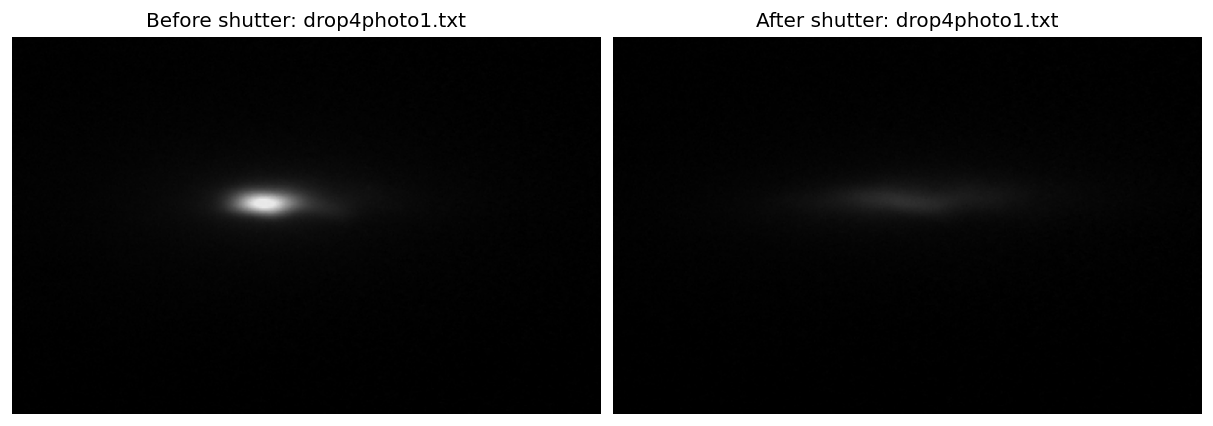

,file,t (ms),shape,max ADU,mean ADU,x0_before (px),y0_before (px),x0_after (px),y0_after (px),waist_before_x (mm),waist_before_y (mm),waist_after_x (mm),waist_after_y (mm),S_ADU,K (atoms*s),Natoms (if t_exp set)
0,drop4photo1.txt,NaN,"(246, 384)",50.0,2.858856,165.202156,108.032193,193.818433,105.865219,0.568604,0.237771,1.841749,0.424047,128526.893992,5654.874085,565487.408472


In [29]:
filename = "drop4photo1.txt"  # change
res1 = analyze_file(filename, show_compare=True, assume_two_frames=True)

pd.DataFrame([{
    "file": res1["file"],
    "t (ms)": res1["t_s"] * 1e3,
    "shape": res1["img_shape"],
    "max ADU": res1["img_max"],
    "mean ADU": res1["img_mean"],

    "x0_before (px)": res1["x0_before_px"],
    "y0_before (px)": res1["y0_before_px"],
    "x0_after (px)":  res1["x0_after_px"],
    "y0_after (px)":  res1["y0_after_px"],

    "waist_before_x (mm)": res1["waist_before_x_mm"],
    "waist_before_y (mm)": res1["waist_before_y_mm"],
    "waist_after_x (mm)":  res1["waist_after_x_mm"],
    "waist_after_y (mm)":  res1["waist_after_y_mm"],

    "S_ADU": res1["S_ADU"],
    "K (atoms*s)": res1["K_atoms_s"],
    "Natoms (if t_exp set)": res1.get("Natoms", np.nan),
}])



In [30]:
print(res1["waist_before_x_mm"])
print(res1["waist_before_y_mm"])
print(res1["waist_after_x_mm"])
print(res1["waist_after_y_mm"])

0.5686044207640482
0.2377706911769545
1.8417493389682709
0.4240470636914344


## 7) TOF sweep: analyze many files

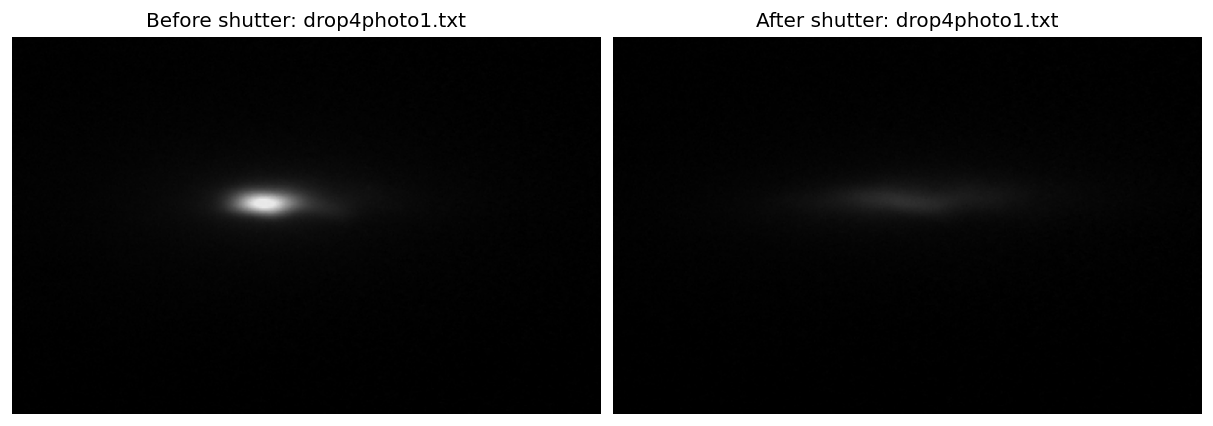

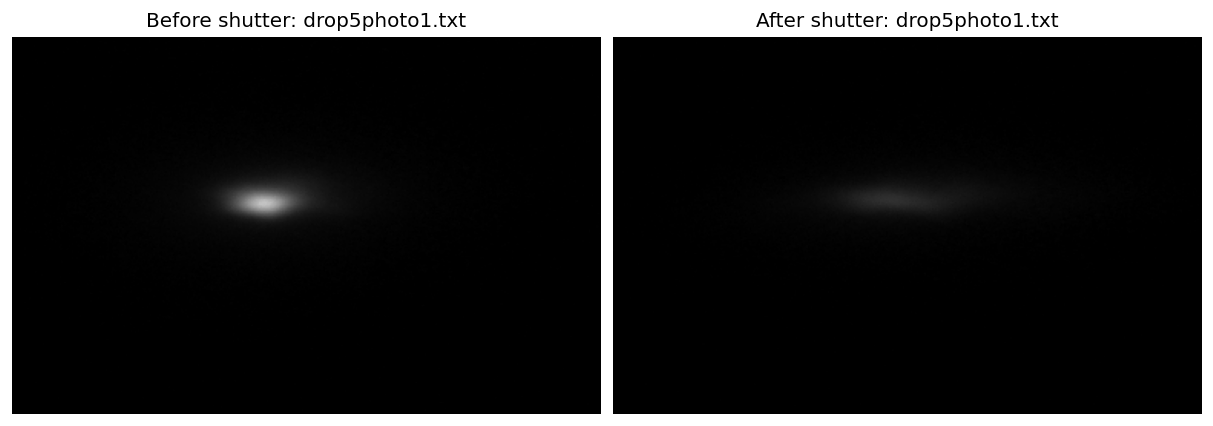

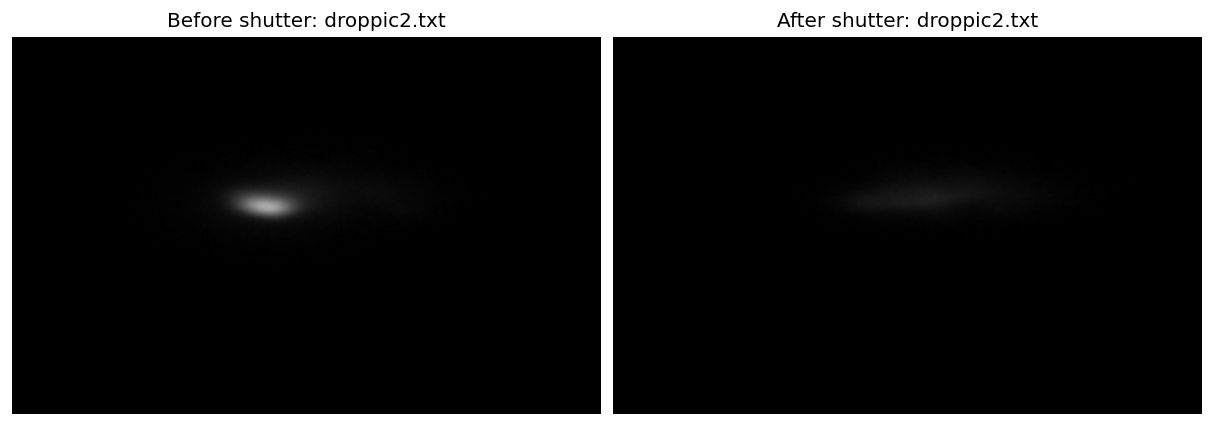

,file,t_s,img_shape,img_max,img_mean,x0_after_px,y0_after_px,w0x_after_px,w0y_after_px,x0_before_px,...,waist_after_y_mm,waist_before_x_mm,waist_before_y_mm,S_ADU,K_atoms_s,Natoms,roi_after,roi_before,fit_after,fit_before
0,drop5photo1.txt,0.010,"(246, 384)",50.0,1.317645,188.504018,105.463926,40.709309,9.203610,164.534305,...,0.360782,0.571102,0.274529,89041.512751,3917.612317,391761.231660,"(0, 384, 0, 246)","(0, 384, 0, 246)","{'Amplitude_Value': 37.823509289178396, 'x0_Va...","{'Amplitude_Value': 166.2206708546743, 'x0_Val..."
1,drop4photo1.txt,0.012,"(246, 384)",50.0,2.858856,193.818433,105.865219,54.813968,10.817527,165.202156,...,0.424047,0.568604,0.237771,128526.893992,5654.874085,565487.408472,"(0, 384, 0, 246)","(0, 384, 0, 246)","{'Amplitude_Value': 34.51409585591555, 'x0_Val...","{'Amplitude_Value': 222.27562954840295, 'x0_Va..."
2,droppic2.txt,0.015,"(246, 384)",33.0,0.635808,206.556467,103.727857,39.119907,8.675294,165.882276,...,0.340072,0.492419,0.227697,56988.031965,2507.336287,250733.628651,"(0, 384, 0, 246)","(0, 384, 0, 246)","{'Amplitude_Value': 26.725331889945195, 'x0_Va...","{'Amplitude_Value': 156.7469275677151, 'x0_Val..."


In [41]:
tof_dataset = [
    # Example:
    ("drop4photo1.txt", 12e-3),
    ("drop5photo1.txt", 10e-3),
    ("droppic2.txt", 15e-3),
]

def analyze_tof_dataset(tof_dataset, *, roi_before=None, roi_after=None, assume_two_frames=True, show_compare=True):
    rows=[]
    for fn, t in tof_dataset:
        r = analyze_file(
            fn,
            roi_before=roi_before,
            roi_after=roi_after,
            show_compare=show_compare,
            assume_two_frames=assume_two_frames,
        )
        r["t_s"] = float(t)
        rows.append(r)
    return pd.DataFrame(rows).sort_values("t_s").reset_index(drop=True)

df = analyze_tof_dataset(tof_dataset, show_compare=True)
df

## 8) TOF physics: velocity, gravity, temperature

In [42]:
def fit_line(x, y):
    """y ≈ a + b x"""
    A = np.vstack([np.ones_like(x), x]).T
    coef, *_ = np.linalg.lstsq(A, y, rcond=None)
    return float(coef[0]), float(coef[1])  # a, b

def fit_y_with_gravity(t, y_m):
    """y(t) = y0 + vy t - 0.5 g t^2"""
    def model(t, y0, vy, g):
        return y0 + vy*t - 0.5*g*t**2
    p0 = (float(y_m[0]), 0.0, 9.8)
    popt, pcov = optimize.curve_fit(model, t, y_m, p0=p0, maxfev=20000)
    perr = np.sqrt(np.diag(pcov))
    return popt, perr

def tof_physics_consistent(df: pd.DataFrame):
    """
    Fits the TOF physics in a way that matches your earlier per-file temperature estimate.

    Conventions:
      - We use centers from Gaussian fits in pixels, converted to object-plane meters via pitch/magnification.
      - We use 'waist_*_mm' quantities defined in analyze_file as:
            waist_mm = 2 * (w0_px * pitch / magnification) in mm.
      - Temperature model consistent with your earlier formula:
            T = m (w_f^2 - w_i^2) / (3 k t^2)
        where w_f is the AFTER width and w_i is the BEFORE width for the same TOF.
    """
    if len(df) < 3:
        raise ValueError("Add at least 3 TOF points to fit velocities and gravity robustly.")

    t = df["t_s"].to_numpy()

    # Centers in meters
    x_after_m = px_to_object_m(df["x0_after_px"].to_numpy(), pitch_m=PIXEL_PITCH_X_M, magnification=MAGNIFICATION)
    y_after_m = px_to_object_m(df["y0_after_px"].to_numpy(), pitch_m=PIXEL_PITCH_Y_M, magnification=MAGNIFICATION)

    x0, vx = fit_line(t, x_after_m)
    (y0, vy, gfit), (y0e, vye, ge) = fit_y_with_gravity(t, y_after_m)

    # --- Temperatures from width differences (your original per-file method)
    m_rb85 = 85 * c.atomic_mass
    wxf = (df["waist_after_x_mm"].to_numpy() * 2 * 1e-3)
    wyf = (df["waist_after_y_mm"].to_numpy() * 2 * 1e-3)
    wxi = (df["waist_before_x_mm"].to_numpy() * 2 * 1e-3)
    wyi = (df["waist_before_y_mm"].to_numpy() * 2 * 1e-3)

    valid = np.isfinite(wxi) & np.isfinite(wyi)
    if not np.all(valid):
        raise ValueError("Some rows are missing before_shutter fits; set assume_two_frames=True and make sure files contain before+after frames.")

    # Compute per-file T estimates
    Tx_i = m_rb85 * (wxf**2 - wxi**2) / (3 * c.k * t**2)
    Ty_i = m_rb85 * (wyf**2 - wyi**2) / (3 * c.k * t**2)

    # Robust summary: median across TOFs (less sensitive to one bad fit)
    Tx_med = float(np.median(Tx_i))
    Ty_med = float(np.median(Ty_i))

    return pd.DataFrame([{
        "vx (m/s)": vx,
        "vy (m/s)": vy,
        "g_fit (m/s^2)": float(gfit),
        "Tx_median (uK)": Tx_med * 1e6,
        "Ty_median (uK)": Ty_med * 1e6,
        "Tx_each (uK)": ", ".join([f"{x*1e6:.1f}" for x in Tx_i]),
        "Ty_each (uK)": ", ".join([f"{y*1e6:.1f}" for y in Ty_i]),
    }])

if len(df) >= 3 and len(tof_dataset) >= 3:
    display(tof_physics_consistent(df))
else:
    print("Add at least 3 (filename, t_TOF) entries in tof_dataset to run the TOF physics fits.")


/var/folders/57/jv5dbbgn2lj2zgt76r3z7z140000gp/T/ipykernel_16948/2066508393.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = optimize.curve_fit(model, t, y_m, p0=p0, maxfev=20000)


,vx (m/s),vy (m/s),g_fit (m/s^2),Tx_median (uK),Ty_median (uK),Tx_each (uK),Ty_each (uK)
0,0.061499,0.082678,7.158706,210.570939,7.46929,"210.6, 290.5, 90.0","7.5, 11.7, 3.9"


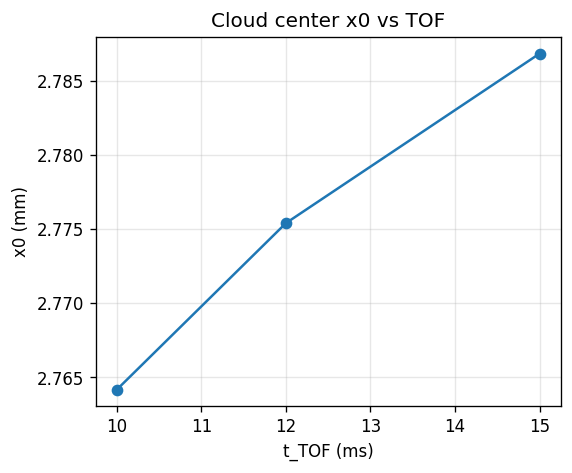

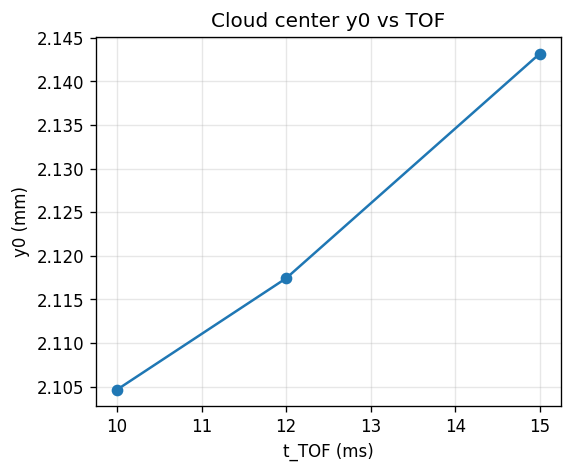

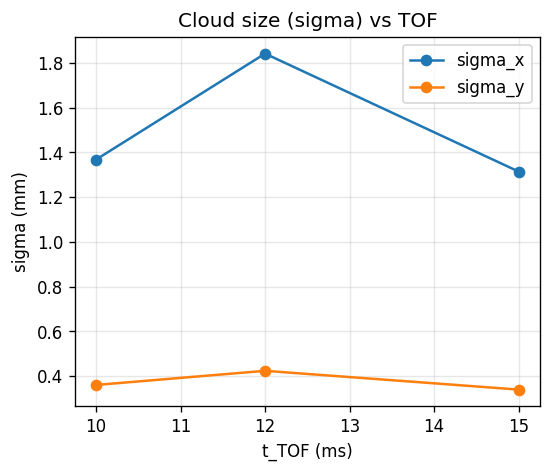

In [35]:
if len(df) >= 2:
    t = df["t_s"].to_numpy()
    x_m = px_to_object_m(df["x0_before_px"].to_numpy(), pitch_m=PIXEL_PITCH_X_M, magnification=MAGNIFICATION)
    y_m = px_to_object_m(df["y0_before_px"].to_numpy(), pitch_m=PIXEL_PITCH_Y_M, magnification=MAGNIFICATION)

    plt.figure(figsize=(5,4))
    plt.plot(t*1e3, x_m*1e3, "o-")
    plt.xlabel("t_TOF (ms)")
    plt.ylabel("x0 (mm)")
    plt.title("Cloud center x0 vs TOF")
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure(figsize=(5,4))
    plt.plot(t*1e3, y_m*1e3, "o-")
    plt.xlabel("t_TOF (ms)")
    plt.ylabel("y0 (mm)")
    plt.title("Cloud center y0 vs TOF")
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure(figsize=(5,4))
    plt.plot(t*1e3, df["waist_after_x_mm"].to_numpy(), "o-", label="sigma_x")
    plt.plot(t*1e3, df["waist_after_y_mm"].to_numpy(), "o-", label="sigma_y")
    plt.xlabel("t_TOF (ms)")
    plt.ylabel("sigma (mm)")
    plt.title("Cloud size (sigma) vs TOF")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


## 9) MOT atom number summary table

In [37]:
if len(df) > 0:
    display(df[["file", "t_s", "img_max", "waist_after_x_mm", "waist_after_y_mm", "S_ADU", "K_atoms_s", "Natoms"]])


,file,t_s,img_max,waist_after_x_mm,waist_after_y_mm,S_ADU,K_atoms_s,Natoms
0,drop5photo1.txt,0.010,50.0,1.367833,0.360782,89041.512751,3917.612317,391761.231660
1,drop4photo1.txt,0.012,50.0,1.841749,0.424047,128526.893992,5654.874085,565487.408472
2,droppic2.txt,0.015,33.0,1.314429,0.340072,56988.031965,2507.336287,250733.628651
